<a href="https://colab.research.google.com/github/Yoshibansal/Pneumonia_detection/blob/main/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Download dataset from link below

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

###Importing libraries

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

#Install tensorflow and numpy if not installed by:-

'''
!pip install numpy
!pip install keras
!pip install tensorflow

or

pip install numpy
pip install keras
pip install tensorflow
'''

#check version
print(tf.__version__) #recommended version -> 2.X

2.3.0


###Data preprocessing

In [ ]:
train_dir = 'chest_xray/train'  #path to the training dataset
validation_dir = 'chest_xray/test'  #path to the test dataset
test_dir = 'chest_xray/val' #path to the validation dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255
                                      ##    '''DATA AUGMENTATION TECHNIQUES'''   ##
#                                     rotation_range=10,
#                                     zoom_range = 0.1,
#                                     width_shift_range=0.1,
#                                     height_shift_range=0.1
                                  )

train_generator = train_datagen.flow_from_directory(
    train_dir,   #path to the training dataset
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE, 
    class_mode ='binary')  #binary.. since we have two classes only

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size=8,
    class_mode='binary')


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


Learn more: -
ImageDataGenerator -> https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

###Model architecture

Sequential model having several convolutional layers followed by maxpooling layers and at the end some fully connected layers (Dense layers).

Activation function -> used "relu" in conv layers and "sigmoid" for last layer.

Used Dropout for regularization

In [ ]:
INPUT_SHAPE = IMAGE_SIZE + (3,)


model = tf.keras.models.Sequential([
                                    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE, padding="same"),
    
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"), #tf.nn.leaky_relu(alpha=0.2)
    
    tf.keras.layers.MaxPool2D(2, 2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(256, activation='relu'),# kernel_regularizer=keras.regularizers.l1_l2(0.01)),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# learning_rate = 1e-4

# model.compile(
#     loss='binary_crossentropy',
#     optimizer=tf.keras.optimizers.RMSprop(lr = learning_rate),#'adam'
#     metrics=['accuracy'])

print(model.summary())   #This will print the summary of the model

###Finding Optimal learning rate

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch))

optimizer = tf.keras.optimizers.Adam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(
    loss='binary_crossentropy', 
    optimizer=optimizer, 
    metrics=['accuracy'])

STEPS_PER_EPOCH = 5216//BATCH_SIZE
VALIDATION_STEPS = 624//BATCH_SIZE

history = model.fit(train_generator, 
                    epochs=6,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    callbacks=[lr_schedule], 
                    validation_data = validation_generator,
                    validation_steps = VALIDATION_STEPS,  
                    verbose=1)

#This is to find the optimal learning rate for this data.
#This makes tunning "learning rate" hyperparameter easy.

Epoch 1/6
163/163 [==============================] - 195s 1s/step - loss: 0.8645 - accuracy: 0.3260 - val_loss: 0.6989 - val_accuracy: 0.4359
Epoch 2/6
163/163 [==============================] - 170s 1s/step - loss: 0.7016 - accuracy: 0.5442 - val_loss: 0.6670 - val_accuracy: 0.6283
Epoch 3/6
163/163 [==============================] - 153s 939ms/step - loss: 0.5776 - accuracy: 0.7335 - val_loss: 0.6495 - val_accuracy: 0.6217
Epoch 4/6
163/163 [==============================] - 154s 945ms/step - loss: 0.4636 - accuracy: 0.7915 - val_loss: 0.5051 - val_accuracy: 0.7961
Epoch 5/6
163/163 [==============================] - 162s 994ms/step - loss: 0.3259 - accuracy: 0.8708 - val_loss: 0.5928 - val_accuracy: 0.6661
Epoch 6/6
163/163 [==============================] - 155s 946ms/step - loss: 0.7316 - accuracy: 0.7909 - val_loss: 0.6651 - val_accuracy: 0.7467


Learn more: -

callbacks.LearningRateScheduler 
https://keras.io/api/callbacks/learning_rate_scheduler/

[1e-08, 0.01, 0, 2]

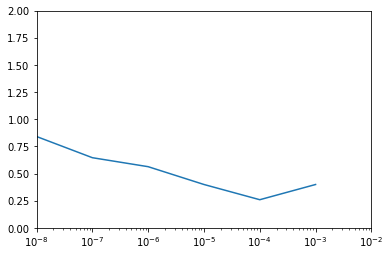

In [ ]:
#plotting loss
import matplotlib.pyplot as plt
lrs = 1e-8 * (10 ** (np.arange(6)))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-2, 0, 2])

#In the graph you can see that 1e-4 (0.0001) is the optimal learning rate

[1e-08, 0.01, 0, 2]

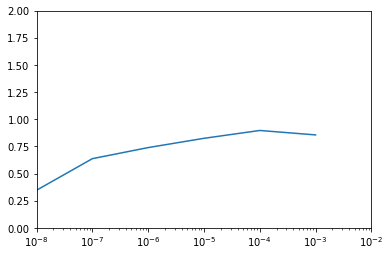

In [ ]:
#plotting accuracy
lrs = 1e-8 * (10 ** (np.arange(6)))
plt.semilogx(lrs, history.history["accuracy"])
plt.axis([1e-8, 1e-2, 0, 2])

#Loking at the graph you can easily conclude the best learning rate for greater accuracy

###Compiling and Training model

In [ ]:
#now we have tunned learning rate (found the best learning rate) for given task
#Let's train the model

learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(lr = learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

In [ ]:
STEPS_PER_EPOCH = 5216//BATCH_SIZE
VALIDATION_STEPS = 624//BATCH_SIZE
EPOCHS = 5

history = model.fit(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH, #100,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,  #50,
    verbose=1)

Epoch 1/5
163/163 [==============================] - 156s 946ms/step - loss: 0.6748 - accuracy: 0.7336 - val_loss: 0.4853 - val_accuracy: 0.7385
Epoch 2/5
163/163 [==============================] - 150s 921ms/step - loss: 0.2411 - accuracy: 0.9124 - val_loss: 0.4809 - val_accuracy: 0.7599
Epoch 3/5
163/163 [==============================] - 151s 922ms/step - loss: 0.1745 - accuracy: 0.9275 - val_loss: 0.4139 - val_accuracy: 0.8026
Epoch 4/5
163/163 [==============================] - 151s 925ms/step - loss: 0.1624 - accuracy: 0.9410 - val_loss: 0.4010 - val_accuracy: 0.8043
Epoch 5/5
163/163 [==============================] - 152s 929ms/step - loss: 0.1464 - accuracy: 0.9447 - val_loss: 0.6471 - val_accuracy: 0.7319


###Visualizing the final results 

accuracy and loss

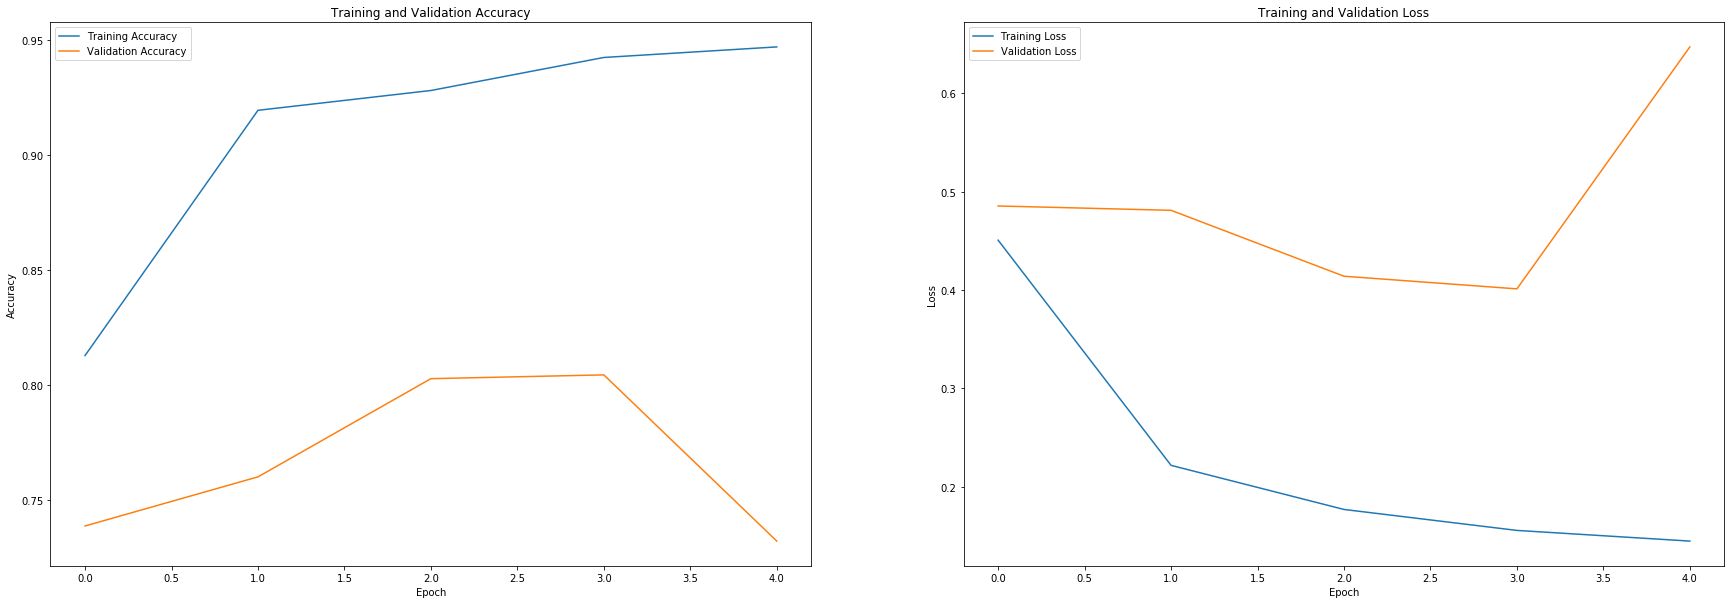

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']   #if you are usinf tf version 1.x then use 'acc' instead of 'accuracy'
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig = plt.subplots(figsize=(30, 10))

plt.subplot(1, 2, 1)
plt.plot(acc)
plt.plot(val_acc)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.subplot(1, 2, 2)
plt.plot(loss)
plt.plot(val_loss)
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

plt.show()


# plt.plot(epochs, acc, 'r', "Training Accuracy")
# plt.plot(epochs, val_acc, 'b', "Validation accuracy")
# plt.title('ACCURACY')
# plt.show()
#
# plt.plot(epochs, loss, 'r', "Training loss")
# plt.plot(epochs, val_loss, 'b', "Validation loss")
# plt.title('LOSS')
# plt.show()

###Evaluting model performance (accuracy) on test data

In [ ]:
print(model.evaluate(test_generator))

###New Prediction

use model for new predictions

In [ ]:
#For colab

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size = IMAGE_SIZE)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

In [ ]:
#Other than colab -> Jupyter notebook

import numpy as np
from keras.preprocessing import image

path = '/path_to/_the_image'
img = image.load_img(path, target_size = IMAGE_SIZE)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
print(fn)
print(classes)

You can increase the model performance by increasing number of layers and parameters but you have to take care of overfitting to reduce that you can use various regularization techniques or by augmentation. If using augmentation, keep in mind that we are working on medical data.